<a href="https://colab.research.google.com/github/marcusnk237/noisy_ecg_to_ecg_ppgs/blob/main/Noisy_ECG_to_ECG_Red_PPG_and_IR_PPG(PTT%2BBIDMC)V3_SNR_Min_Max_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

The goal of this projet is to generate from noisy ECG signals:
- Clean ECG signal
- Clean Red Light PPG signal
- Clean Infrared Light PPG Signal

The clean PPG signals will be use to compute SpO2, and the clean ECG will be use for Heartrate computation

The model code is inspired by <a href=" https://github.com/pritamqu/ppg2ecg-cardiogan" > Cardiogan</a>



# Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load libraries

In [ ]:
!pip install tensorflow_addons
!pip install biosppy
!pip install matplotx
import cv2,gc,os,random,sklearn,itertools,scipy,logging,biosppy
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from sklearn.utils import resample,shuffle
from scipy.interpolate import CubicSpline
from random import choice,randint
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import signal
import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from biosppy.signals import tools as tools



from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras import Model,Sequential,regularizers
from tensorflow.keras.layers import MaxPool1D , Dense, Conv2D , Conv2DTranspose, Input , MaxPooling1D ,  Flatten , add , Dropout , BatchNormalization , LayerNormalization
from tensorflow.keras.activations import relu , tanh , sigmoid , softmax
from tensorflow_addons.layers import InstanceNormalization
from scipy import stats
from tensorflow import random_normal_initializer,squeeze

from collections import Counter
# Generate and plot a synthetic imbalanced classification dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

#### Import libraries

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# Set random seed
np.random.seed(123)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 2.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
<ipython-input-2-e85ded150a9e>:37: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# Set random seed
np.random.seed(123)

In [ ]:
tf.version.VERSION

'2.12.0'

# Voltage conversion
For real data testing purpose

In [ ]:
def voltage(x):
  return ((3.3*1000)/(550*1023))*x

# SpO2 Formula

In [ ]:
def  getSpO2(R,I):

  ratio_of_red=np.max(R) - np.min(R)
  ratio_of_ir=(np.max(I) - np.min(I))

  ratio_of_ratios = ratio_of_red/ratio_of_ir

  spo2=min(11.78*(ratio_of_ratios*ratio_of_ratios*ratio_of_ratios) - 55.92*(ratio_of_ratios*ratio_of_ratios) + 28.84*ratio_of_ratios + 97.12,100)

  return spo2

In [ ]:
def  computeSpO2(R,I):

  ratio_of_red=(np.max(R) - np.min(R))/np.min(R)
  ratio_of_ir=(np.max(I) - np.min(I))/np.min(I)

  ratio_of_ratios = ratio_of_red/ratio_of_ir

  spo2=min(11.78*(ratio_of_ratios*ratio_of_ratios*ratio_of_ratios) - 55.92*(ratio_of_ratios*ratio_of_ratios) + 28.84*ratio_of_ratios + 97.12,100)

  return spo2

# Data loading
We save the augmented dataset to npy files.
The datas consists of :
- The Noisy ECG signals (input)
- Clean ECG , PPG IR and PPG Red signals (outputs)

The min max method used was mean normalization.
Dimension expansion was already performs


In [ ]:
noisy_X_test=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/noisy_X_test.npy")
noisy_X_val=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/noisy_X_val.npy")
noisy_X_train=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/noisy_X_train.npy")

X_test_ecg=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/ECG_X_test.npy")
X_val_ecg=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/ECG_X_val.npy")
X_train_ecg=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/ECG_X_train.npy")

X_test_red=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/RED_X_test.npy")
X_val_red=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/RED_X_val.npy")
X_train_red=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/RED_X_train.npy")

X_test_ir=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/IR_X_test.npy")
X_val_ir=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/IR_X_val.npy")
X_train_ir=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/IR_X_train.npy")

# Signal generation with GAN

## Layers
Layers used for the model:
- Dense Layer
- Conv1D Layer
- DeConv1D Layer
- Activations functions (sigmoid, relu, tanh, leaky_relu,softmax)
- Dropout
- Normalization ( layer normalization, batch normalization)
- Attention block (adopted from https://github.com/lixiaolei1982/Keras-Implementation-of-U-Net-R2U-Net-Attention-U-Net-Attention-R2U-Net.-/blob/master/network.py)


In [ ]:
weights_initializer = random_normal_initializer(mean=0.0, stddev=0.02, seed=None)

def Dense(units, activation=None):
    op = Dense(units=units, activation=activation, use_bias=True, kernel_initializer=weights_initializer,
                               bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                               kernel_constraint=None, bias_constraint=None)

    return op

def Conv1D(filters, kernel_size, strides=1, padding='valid', activation=None, use_bias=True):
    op = Conv2D(filters=filters, kernel_size=(1, kernel_size), strides=(1, strides), padding=padding, data_format='channels_last',
                                dilation_rate=1, activation=None, use_bias=use_bias,
                                kernel_initializer=weights_initializer, bias_initializer='zeros',
                                kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                                kernel_constraint=None, bias_constraint=None)

    return op

Conv2D = Conv2D

def DeConv1D(filters, kernel_size, strides=1, padding='valid', use_bias=True):
    op = Conv2DTranspose(filters= filters, kernel_size=(1, kernel_size), strides=(1, strides), padding=padding,
                                         output_padding=None, data_format=None, dilation_rate=(1, 1), activation=None, use_bias=use_bias,
                                         kernel_initializer=weights_initializer, bias_initializer='zeros', kernel_regularizer=None,
                                         bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

    return op

def BatchNormalization(trainable=True, virtual_batch_size=None):
    op = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
                                            beta_initializer='zeros', gamma_initializer='ones',
                                            moving_mean_initializer='zeros', moving_variance_initializer='ones',
                                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
                                            gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.99,
                                            fused=None, trainable=trainable, virtual_batch_size=virtual_batch_size, adjustment=None, name=None)

    return op

def Activation(x, activation):
    if activation == 'relu':
        return relu(x, alpha=0.0, max_value=None, threshold=0)
    elif activation == 'leaky_relu':
        return relu(x, alpha=0.3, max_value=None, threshold=0)
    elif activation == 'sigmoid':
        return sigmoid(x)
    elif activation == 'softmax':
        return softmax(x, axis=-1)
    elif activation == 'tanh':
        return tanh(x)
    else:
        raise ValueError('please check the name of the activation')


def Dropout(rate):
    op = Dropout(rate=rate, noise_shape=None, seed=None)
    return op

def flatten():
    op = Flatten(data_format=None)
    return op

def normalization(name):

    if name =='none':
        return lambda: lambda x: x
    elif name == 'batch_norm':
        return keras.layers.BatchNormalization()
    elif name == 'instance_norm':
        return InstanceNormalization()
    elif name == 'layer_norm':
        return LayerNormalization()

def attention_block_1d(curr_layer, conn_layer):
    inter_channel = curr_layer.get_shape().as_list()[3]
    theta_x = Conv1D(inter_channel, 1, 1)(conn_layer)
    phi_g = Conv1D(inter_channel, 1, 1)(curr_layer)
    f = Activation(keras.layers.add([theta_x, phi_g]), 'leaky_relu')
    psi_f = Conv1D(1, 1, 1)(f)
    rate = Activation(psi_f, 'sigmoid')
    att_x = keras.layers.multiply([conn_layer, rate])
    return att_x

## Model

In [ ]:
def generator_attention(input_shape=512,
                      filter_size=[16,64,64,64,64,64,64,16],
                      kernel_size=[32,32,32,32,32,32,32,32],
                      n_downsample=8,
                      norm='layer_norm',
                      skip_connection=True):

    """
    input_shape = 128*1

    """

    ########################  downsampling function ########################
    def _downsample(ip, filter_size, kernel_size, norm, stride_size=2):

        ip = Conv1D(filters=filter_size, kernel_size=kernel_size, strides=stride_size, padding='same', use_bias=False)(ip)
        if norm != 'none':
            ip = normalization(norm)(ip)
        ip = Activation(ip, activation='leaky_relu')
        return ip
    ######################## Upsampling function ########################
    def _upsample(ip, filter_size, kernel_size, norm, stride_size=2, drop_rate = 0.5, apply_dropout=False):

        ip = DeConv1D(filters=filter_size, kernel_size=kernel_size, strides=stride_size, padding='same', use_bias=False)(ip)
        if norm != 'none':
            ip = normalization(norm)(ip)
        if apply_dropout:
            ip = Dropout(rate=drop_rate)
        ip = Activation(ip, activation='relu')

        return ip


    ## input
    h = inputs = keras.Input(shape=input_shape) # None, 128
    h = tf.expand_dims(h, axis=1) # None, 1, 128
    h = tf.expand_dims(h, axis=3) # None, 1, 128, 1
    ######################## downsampling ########################
    connections = []
    for k in range(n_downsample):
        if k==0:
            h =  _downsample(h, filter_size[k], kernel_size[k], norm)
        else:
            h =  _downsample(h, filter_size[k], kernel_size[k], norm)

        connections.append(h)

    ######################## upsampling ########################`
    h = _upsample(h, filter_size[k], kernel_size[k], norm, stride_size=1)
    if skip_connection:
        _h = attention_block_1d(curr_layer= h, conn_layer= connections[n_downsample-1])
        h  = keras.layers.add([h, _h])

    for l in range(1, n_downsample):
        h  = _upsample(h, filter_size[k-l], kernel_size[k-l], norm)
        if skip_connection:
            _h = attention_block_1d(curr_layer= h, conn_layer= connections[k-l])
            h  = keras.layers.add([h, _h])

    ## outputs
    h_ecg = DeConv1D(filters=1, kernel_size=kernel_size[k-l], strides=2, padding='same')(h)
    h_ecg = Activation(h_ecg, activation='tanh')
    h_ecg = tf.squeeze(h_ecg, axis=1)
    h_ecg = tf.squeeze(h_ecg, axis=2)

    h_ac_red = DeConv1D(filters=1, kernel_size=kernel_size[k-l], strides=2, padding='same')(h)
    h_ac_red = Activation(h_ac_red ,activation='tanh')
    h_ac_red = tf.squeeze(h_ac_red, axis=1)
    h_ac_red = tf.squeeze(h_ac_red, axis=2)

    h_ac_ir = DeConv1D(filters=1, kernel_size=kernel_size[k-l], strides=2, padding='same')(h)
    h_ac_ir = Activation(h_ac_ir, activation='tanh')
    h_ac_ir = tf.squeeze(h_ac_ir, axis=1)
    h_ac_ir = tf.squeeze(h_ac_ir, axis=2)

    return keras.Model(inputs=inputs, outputs=[h_ecg,h_ac_red,h_ac_ir] , name = 'noisy_to_ecg_red_ir')

### SNR

In [ ]:
import numpy as np
import scipy.io as sio

def calculateSNR(testy, predictions):
    try:
        SNR_after =  10 * np.log10(np.mean(np.square(testy), axis = 0)  / np.mean(np.square(predictions - testy), axis = 0))
    except:
        SNR_after =-3
    return SNR_after

### SNR Improvement

In [ ]:
import numpy as np
import scipy.io as sio

def calculateSNRImprovement(testX, testy, predictions):
    try:
      SNR_imp = 10 * np.log10(np.sum(np.square(testX - testy), axis = 0) / np.sum(np.square(predictions - testy), axis = 0))
    except:
      SNR_imp = -3
    try:
       SNR_before =  10 * np.log10(np.mean(np.square(testy), axis = 0) / np.mean(np.square(testX - testy), axis = 0))
    except:
       SNR_before = -3
    try:
        SNR_after =  10 * np.log10(np.mean(np.square(testy), axis = 0)  / np.mean(np.square(predictions - testy), axis = 0))
    except:
        SNR_after =-3
    return SNR_before, SNR_after, SNR_imp

## Training

In [ ]:
N=X_train_ir.shape[0]
batch_size = 2* tpu_strategy.num_replicas_in_sync
iterations = N/batch_size
step_size= 2 * iterations

def scale_fn(x):
  return tf.pow(0.95,x)

lr_schedule = CyclicalLearningRate(1e-6, 1e-4, step_size=step_size, scale_fn=scale_fn)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
with tpu_strategy.scope():
  gan = generator_attention()
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) # Early stopping parameters
  save_best_weights = ModelCheckpoint(filepath="autoencoder_ecg_red_ir_06500.hdf5", verbose=2, save_best_only=True , restore_best_weights=True) # Model checkpoint parameters

  gan.compile(optimizer=optimizer,
              loss = {
                  gan.get_layer(index = -3).name : 'mse',
                  gan.get_layer(index = -2).name : 'mse' ,
                  gan.get_layer(index = -1).name : 'mse'
                  },
              metrics = {
                  gan.get_layer(index = -3).name: ['mae',tf.keras.metrics.RootMeanSquaredError()],
                  gan.get_layer(index = -2).name: ['mae',tf.keras.metrics.RootMeanSquaredError()],
                  gan.get_layer(index = -1).name: ['mae',tf.keras.metrics.RootMeanSquaredError()]
                 }
        )
  history = gan.fit( noisy_X_train, [X_train_ecg,X_train_red,X_train_ir] , validation_data=(noisy_X_val, [X_val_ecg,X_val_red,X_val_ir]), batch_size=batch_size, epochs=100, callbacks=[save_best_weights,early_stopping])
  np.save("/content/drive/MyDrive/RESVIDLSTM/Final_Dataset/Models_Trained/125/autoencoders/autoencoder_ecg_red_ir_06500.npy",history.history)

Epoch 1/100
5479/5479 [==============================] - ETA: 0s - loss: 0.0613 - tf.compat.v1.squeeze_1_loss: 0.0099 - tf.compat.v1.squeeze_3_loss: 0.0133 - tf.compat.v1.squeeze_5_loss: 0.0380 - tf.compat.v1.squeeze_1_mae: 0.0623 - tf.compat.v1.squeeze_1_root_mean_squared_error: 0.0996 - tf.compat.v1.squeeze_3_mae: 0.0830 - tf.compat.v1.squeeze_3_root_mean_squared_error: 0.1155 - tf.compat.v1.squeeze_5_mae: 0.1464 - tf.compat.v1.squeeze_5_root_mean_squared_error: 0.1949
Epoch 1: val_loss improved from inf to 0.03503, saving model to autoencoder_ecg_red_ir_06500.hdf5
5479/5479 [==============================] - 211s 34ms/step - loss: 0.0613 - tf.compat.v1.squeeze_1_loss: 0.0099 - tf.compat.v1.squeeze_3_loss: 0.0133 - tf.compat.v1.squeeze_5_loss: 0.0380 - tf.compat.v1.squeeze_1_mae: 0.0623 - tf.compat.v1.squeeze_1_root_mean_squared_error: 0.0996 - tf.compat.v1.squeeze_3_mae: 0.0830 - tf.compat.v1.squeeze_3_root_mean_squared_error: 0.1155 - tf.compat.v1.squeeze_5_mae: 0.1464 - tf.compat.

### Evaluation

In [ ]:
model_evaluation = gan.evaluate(noisy_X_test, [X_test_ecg,X_test_red,X_test_ir]) # Evaluate model

538/538 [==============================] - 17s 27ms/step - loss: 0.0078 - tf.compat.v1.squeeze_1_loss: 7.8297e-04 - tf.compat.v1.squeeze_3_loss: 0.0022 - tf.compat.v1.squeeze_5_loss: 0.0048 - tf.compat.v1.squeeze_1_mae: 0.0186 - tf.compat.v1.squeeze_1_root_mean_squared_error: 0.0280 - tf.compat.v1.squeeze_3_mae: 0.0259 - tf.compat.v1.squeeze_3_root_mean_squared_error: 0.0464 - tf.compat.v1.squeeze_5_mae: 0.0389 - tf.compat.v1.squeeze_5_root_mean_squared_error: 0.0695


## SNR estimation

#### Generate estimated ECG and PPG signals

In [ ]:
ecgs,reds,irs = decoded_ecgs = gan(noisy_X_test)

#### Get PPG Signals

In [ ]:
reds_predict=reds.numpy()
red_inputs = X_test_red.reshape(X_test_red.shape[0], X_test_red.shape[1])

irs_predict=irs.numpy()
ir_inputs = X_test_ir.reshape(X_test_ir.shape[0], X_test_ir.shape[1])

#### Get ECG Signal

In [ ]:
ecgs_predict=ecgs.numpy()
noises = noisy_X_test.reshape(noisy_X_test.shape[0], noisy_X_test.shape[1])
inputs = X_test_ecg.reshape(X_test_ecg.shape[0], X_test_ecg.shape[1])

#### Initialize array for SNR estimations

In [ ]:
SNR_befores_ecg, SNR_afters_ecg, SNR_imps_ecg, SNR_after_reds , SNR_after_irs = [],[],[],[],[]

#### Compute SNR Improvement for each signal

In [ ]:
for i in range(len(ecgs_predict)):
  try:
     SNR_before, SNR_after, SNR_imp = calculateSNRImprovement(noises[i],inputs[i],ecgs_predict[i])
     SNR_imps_ecg.append(SNR_imp)
  except:
    print(i)

<ipython-input-12-e5330d26e8ab>:6: RuntimeWarning: divide by zero encountered in log10
  SNR_imp = 10 * np.log10(np.sum(np.square(testX - testy), axis = 0) / np.sum(np.square(predictions - testy), axis = 0))
<ipython-input-12-e5330d26e8ab>:10: RuntimeWarning: divide by zero encountered in double_scalars
  SNR_before =  10 * np.log10(np.mean(np.square(testy), axis = 0) / np.mean(np.square(testX - testy), axis = 0))


#### Regroup SNR Improvement values

In [ ]:
SNRImprovment = np.array(SNR_imps_ecg)
SNRDf = pd.DataFrame(SNRImprovment)

#### Replace undefined values by 0

In [ ]:
SNRDf.replace([np.inf, -np.inf], 0, inplace=True)

#### Compute average SNR Improvement

In [ ]:
SNR = SNRDf.to_numpy()
(np.mean(SNR))

10.43565259442634

#### Compute SNR for PPG Red and PPG IR signals

In [ ]:
############## Compute SNR for each signal #########################################""
SNR_after_reds , SNR_after_irs=[],[]
for i in range(len(reds_predict)):
  try:
     SNR_after_red= calculateSNR(red_inputs[i],reds_predict[i])
     SNR_after_ir= calculateSNR(ir_inputs[i],irs_predict[i])
     SNR_after_reds.append(SNR_after_red)
     SNR_after_irs.append(SNR_after_ir)
  except:
    print(i)

########### Return the average SNR for PPG red ####################
print(np.mean(SNR_after_reds))

########### Return the average SNR for PPG ir ####################
print(np.mean(SNR_after_irs))

20.266996464171427
22.84099005040483


### Plot Loss curves

In [ ]:
K= list(history.history.keys())

#### ECG loss

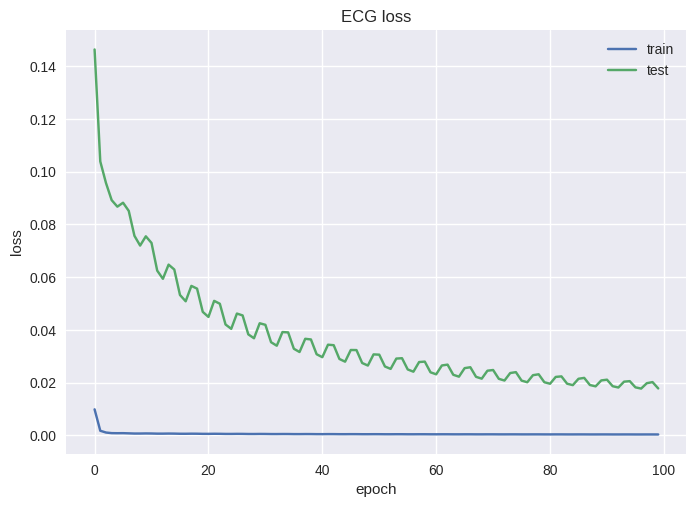

In [ ]:
plt.plot(history.history[K[1]])
plt.plot(history.history[K[8]])
plt.title('ECG loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### RED PPG Loss

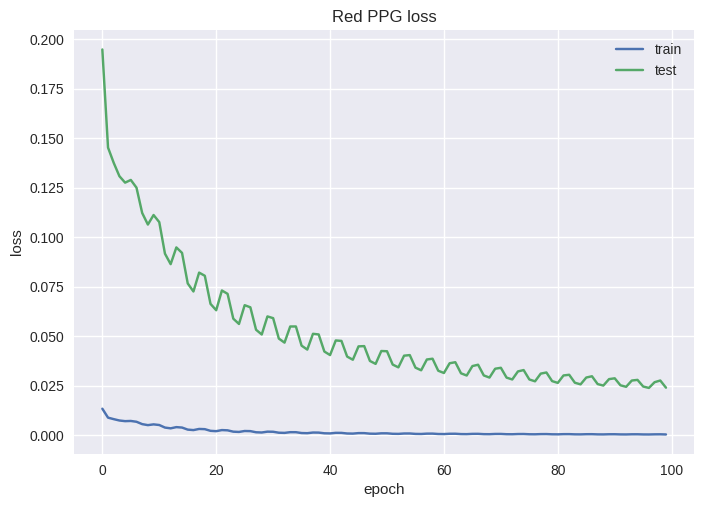

In [ ]:
plt.plot(history.history[K[2]])
plt.plot(history.history[K[9]])
plt.title('Red PPG loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### IR PPG Loss

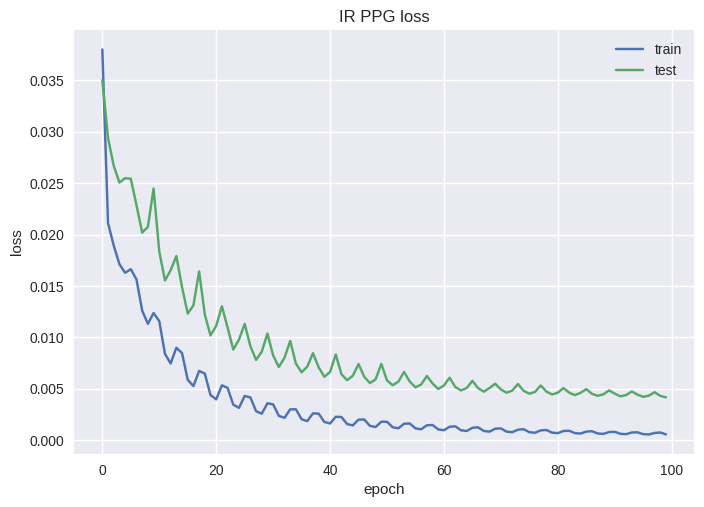

In [ ]:
plt.plot(history.history[K[3]])
plt.plot(history.history[K[10]])
plt.title('IR PPG loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### ECG MAE

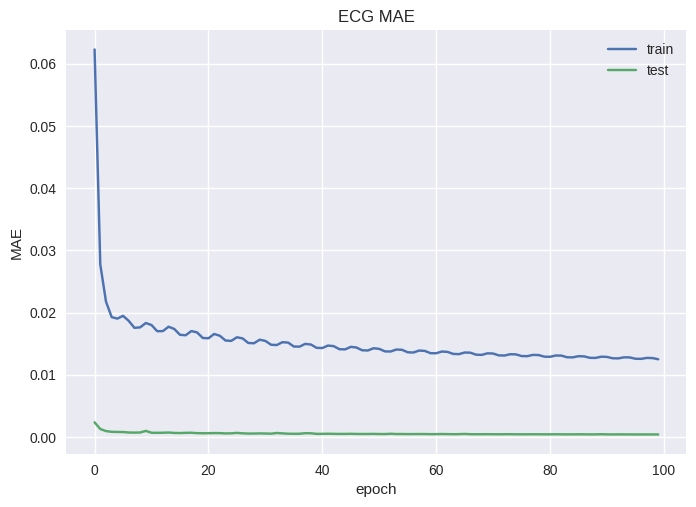

In [ ]:
plt.plot(history.history[K[4]])
plt.plot(history.history[K[11]])
plt.title('ECG MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### RED PPG MAE

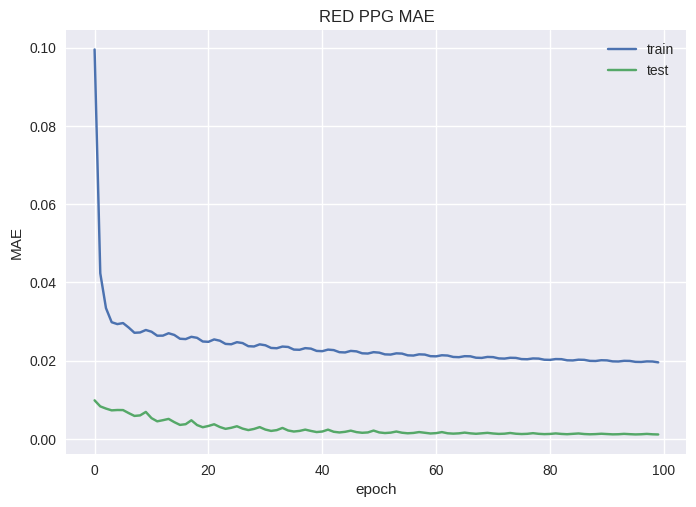

In [ ]:
plt.plot(history.history[K[5]])
plt.plot(history.history[K[12]])
plt.title('RED PPG MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### IR PPG MAE

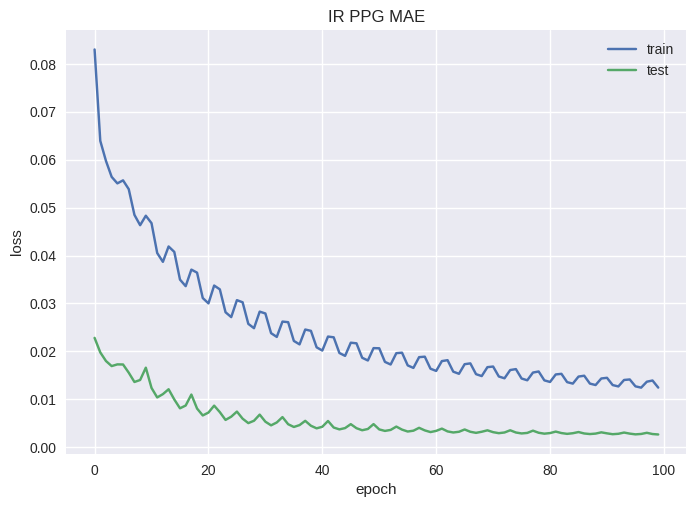

In [ ]:
plt.plot(history.history[K[6]])
plt.plot(history.history[K[13]])
plt.title('IR PPG MAE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### Global loss

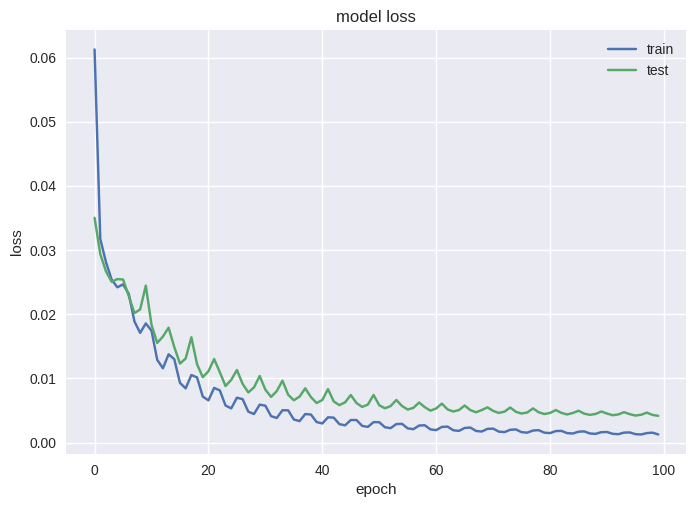

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Test with real ECG

We test our model with a noisy recorded ECG

<ipython-input-32-8f621f61a057>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


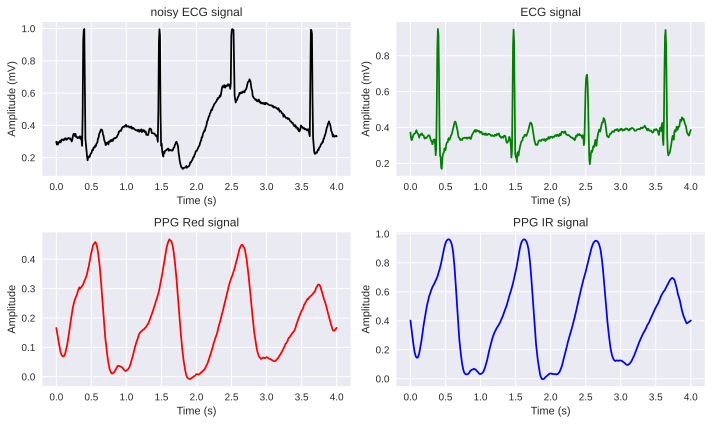

In [ ]:
s3=[]
Fs=128
t_p = np.linspace(0,4,4*Fs)

f = open('/content/drive/MyDrive/Arduino_Signals/250/ECG_Arduino.txt','r')

for row in f:
    rows = row.split('\n')
    s3.append(voltage(float(rows[0])))
L = (s3-np.min(s3))/(np.max(s3)-np.min(s3))
#L=s3/np.max(s3)
#L=s3
i=800

signal_noisy=signal.resample(L[i:i+1000], 512)

ecg_ppg_signals= gan(np.array([signal_noisy]))
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

axis[0, 0].plot(t_p,signal_noisy,color='black')
axis[0, 0].set(xlabel='Time (s)', ylabel='Amplitude (mV)',title='noisy ECG signal' )

axis[0, 1].plot(t_p,ecg_ppg_signals[0][0],color='green')
axis[0, 1].set(xlabel='Time (s)', ylabel='Amplitude (mV)',title='ECG signal')

axis[1, 0].plot(t_p,ecg_ppg_signals[1][0],color='red')
axis[1, 0].set(xlabel='Time (s)', ylabel='Amplitude',title='PPG Red signal')

axis[1, 1].plot(t_p,ecg_ppg_signals[2][0],color='blue')
axis[1, 1].set(xlabel='Time (s)', ylabel='Amplitude',title='PPG IR signal')
figure.tight_layout()
plt.show()
figure.savefig('data.tif', format='tif', dpi=300)


# Comparison with data recorded with oxymeter and ECG sensor

## Load datas

In [ ]:
ecg_arduinos,ppg_red_arduino,ppg_ir_arduino=[],[],[]
f = open('/content/PPGECG.txt','r')

for row in f:
    rows = row.split('\t')
    try:
      ecg_arduinos.append(float(rows[0]))
    except:
      pass
    try:
      ppg_red_arduino.append(float(rows[1]))
    except:
      pass
    try:
       r = rows[2].split('\n')
       ppg_ir_arduino.append(float(r[0]))
    except:
      pass




## Min Max normalization

In [ ]:
q=500
ecg_arduino = (ecg_arduinos[q:q+512]-np.min(ecg_arduinos[q:q+512]))/(np.max(ecg_arduinos[q:q+512])-np.min(ecg_arduinos[q:q+512]))
red_arduino = (ppg_red_arduino[q:q+512]-np.min(ppg_ir_arduino[q:q+512]))/(np.max(ppg_red_arduino[q:q+512])-np.min(ppg_red_arduino[q:q+512]))
ir_arduino = (ppg_ir_arduino[q:q+512]-np.min(ppg_ir_arduino[q:q+512]))/(np.max(ppg_ir_arduino[q:q+512])-np.min(ppg_ir_arduino[q:q+512]))
ecg_ppg_signals= gan(np.array([ecg_arduino]))

## Plot results

In [ ]:
figure, axis = plt.subplots(nrows=3, ncols=1, figsize=(10, 7))
axis[0].plot(t_p,ecg_arduino,color='black',label="Noisy measured ECG signal")
axis[0].plot(t_p,ecg_ppg_signals[0][0],color='green',label='Reconstructed ECG signal')
axis[0].fill_between(t_p,ecg_ppg_signals[0][0],ecg_arduino, color='lightcoral')
axis[0].legend(loc='upper left')
axis[0].set(xlabel='Time (s)', ylabel='Amplitude (mV)')
axis[0].set_xlim([0, 4])
axis[0].set_ylim([0, 1.25])

axis[1].plot(t_p,red_arduino,color='yellow',label='measured PPG Red signal')
axis[1].plot(t_p,ecg_ppg_signals[1][0],color='red',label='Reconstructed PPG Red signal')
axis[1].fill_between(t_p,ecg_ppg_signals[1][0],red_arduino, color='lightcoral')
axis[1].legend(loc='upper left')
axis[1].set(xlabel='Time (s)', ylabel='Amplitude')
axis[1].set_xlim([0, 4])
axis[1].set_ylim([0, 1])

axis[2].plot(t_p,ir_arduino,color='yellow',label='measured PPG IR signal')
axis[2].plot(t_p,ecg_ppg_signals[2][0],color='blue',label='Reconstructed PPG IR signal')
axis[2].fill_between(t_p,ecg_ppg_signals[2][0],ir_arduino, color='lightcoral', label = '')
axis[2].legend(loc='upper left')
axis[2].set(xlabel='Time (s)', ylabel='Amplitude')
axis[2].set_xlim([0, 4])
axis[2].set_ylim([0, 1.25])


figure.tight_layout()
plt.legend()
plt.show()
figure.savefig('data_comparison.jpg', format='jpg', dpi=300)